# Data processing

In [2]:
import os
import pprint
import math

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

data_folder = os.path.join(".", os.pardir, os.pardir, "data")
raw_data_folder = os.path.join(data_folder, "RAW")
processed_data_folder = os.path.join(data_folder, "processed")

print(data_folder)
print(raw_data_folder)

./../../data
./../../data/RAW


## ARotor

Kongsberg test rig

### Process

In [95]:
arotor_data_folder = os.path.join(raw_data_folder, "ARotor")

class_num = 1
class_mapping = {}

arotor_data = []

for _, dirnames, _ in os.walk(arotor_data_folder):
    for dirname in sorted(dirnames):
        print(dirname)
        for dirpath, _, filenames in os.walk(os.path.join(arotor_data_folder, dirname)):
            for filename in filenames:
                # Load file
                df_tmp = pd.read_csv(os.path.join(dirpath, filename), delimiter=";")

                # Other sensors
                 # * Cut 500 because of irregularities at end of measurements
                 # * Cut additional 2 to match encoder acceleration
                df = df_tmp.loc[:, [
                    'acc1',
                    'acc2',
                    'acc3',
                    'acc4',
                    'torque1',
                    'torque2']].iloc[:-502, :]

                # Encoders
                 # * Cut 500 because of irregularities at end of measurements
                df_enc_tmp = df_tmp.loc[:, [
                    'en1time',
                    'en1angle',
                    'en2time',
                    'en2angle',
                    'en3time',
                    'en3angle',
                    'en4time',
                    'en4angle',
                    'en5time',
                    'en5angle']].iloc[:-500, :]

                # Transform encoders data to speed and acceleration
                df_enc = []
                for i in range(1, 6):
                    a_speed = np.diff(df_enc_tmp[f"en{i}angle"]) / np.diff(df_enc_tmp[f"en{i}time"])
                    a_acc = np.diff(a_speed) / np.diff(df_enc_tmp[f"en{i}time"][:-1])
                    # Alternative
                    b_speed = np.gradient(df_enc_tmp[f"en{i}angle"], df_enc_tmp[f"en{i}time"])
                    b_acc = np.gradient(b_speed, df_enc_tmp[f"en{i}time"])

                    df_enc.append(pd.DataFrame({
                        f"en{i}speed": a_speed[:-1],
                        f"en{i}acc": a_acc,
                        f"en{i}speed_grad": b_speed[:-2],
                        f"en{i}acc_grad": b_acc[:-2]
                    }))
                df_enc = pd.concat(df_enc, axis=1)

                # Combine sensors data
                df = pd.concat([df, df_enc], axis=1)

                # Add rpm and class info
                info = filename.split("rpm")
                df["rpm"] = int(info[0])

                if "no_sim" in dirname:
                    df["class"] = 0
                    class_mapping[dirname.replace("_csv", "")] = 0
                else:
                    df["class"] = class_num
                    class_mapping[dirname.replace("_csv", "")] = class_num

                arotor_data.append(df)
        if not "no_sim" in dirname:
            class_num += 1
        
arotor_data = pd.concat(arotor_data)
arotor_data = arotor_data.reset_index(drop=True)

# * Cut 500 last samples from all sensors because of irregularities


# Swap acceloremeters 2 and 4
# * This is done so that Acc 1, 2, and 3 refer to the ones on top of the gearbox and 4 the one further away
arotor_data[["acc2", "acc4"]] = arotor_data[["acc4", "acc2"]]

# * Conversion done because final computations are done with float32 anyway
# Get float 64 columns
float64_cols = list(arotor_data.select_dtypes(include='float64'))
# Convert those columns float 32
arotor_data[float64_cols] = arotor_data[float64_cols].astype('float32')

print()
print("Class mapping:")
pprint.pprint(class_mapping)

001_1sim_csv
001_2sim_csv
001_3sim_csv
003_1sim_csv
003_2sim_csv
003_3sim_csv
005_1sim_csv
005_2sim_csv
005_3sim_csv
no_sim_csv

Class mapping:
{'001_1sim': 1,
 '001_2sim': 2,
 '001_3sim': 3,
 '003_1sim': 4,
 '003_2sim': 5,
 '003_3sim': 6,
 '005_1sim': 7,
 '005_2sim': 8,
 '005_3sim': 9,
 'no_sim': 0}


In [96]:
# Show processed data shape

arotor_data.head()

,acc1,acc2,acc3,acc4,torque1,torque2,en1speed,en1acc,en1speed_grad,en1acc_grad,...,en4speed,en4acc,en4speed_grad,en4acc_grad,en5speed,en5acc,en5speed_grad,en5acc_grad,rpm,class
0,1.837953,1.645023,1.873710,0.695454,0.942261,3.973999,6034.573242,-26302.613281,6034.573242,-13200.700195,...,-1978.928101,-35599.300781,-1978.928101,-17608.083984,496.856323,4453.003418,496.856323,2229.751465,1000,1
1,-0.786764,-2.787747,-4.137097,-6.515445,0.722656,3.989563,6025.786133,-51919.605469,6030.163086,-26210.714844,...,-1990.585083,21262.785156,-1984.693848,-12359.009766,498.308197,8843.856445,497.583313,4333.756836,1000,1
2,-1.084027,0.395010,-0.497809,0.072936,1.012451,3.995972,6008.570801,98345.015625,6017.190918,-7914.744141,...,-1983.471069,-29985.498047,-1987.034424,-5811.840332,501.183350,5569.745605,499.674255,6767.647949,1000,1
3,3.178846,0.819396,2.087222,-7.280841,0.734131,3.926392,6041.272949,-138405.281250,6024.966309,1816.521240,...,-1993.539429,-34228.750000,-1988.586914,-18617.154297,503.183716,-7007.548828,502.238159,3079.748291,1000,1
4,-0.377739,-1.216127,-0.765620,-5.330565,1.072510,3.825378,5995.499023,138727.046875,6018.473145,-9510.172852,...,-2004.665527,-59904.000000,-1999.041748,-39316.921875,500.927643,-5488.468750,502.058228,-3390.718994,1000,1


In [97]:
arotor_data.groupby(["rpm", "class"]).first()

acc1      acc2      acc3      acc4   torque1    torque2  \
rpm  class                                                                
250  0     -0.192631 -0.154310 -0.248390 -1.462964  0.467285   2.574158   
     1      0.123867  0.226329  0.115036  0.809872  0.574585   3.626404   
     2     -0.656815 -0.042250 -0.000543  0.220585  0.718872   4.233093   
     3      0.131988 -0.102686  0.111050  0.586256  0.681763   4.567871   
     4     -0.138294 -0.172928  0.056844  0.122894  0.628174   3.114624   
     5     -0.147630 -0.060830 -0.251683 -1.220955  0.619263   4.122314   
     6     -0.026027 -0.132811 -0.080102  0.732502  0.729004   4.586792   
     7      0.135599 -0.124934  0.063281 -1.603840  0.529907   2.978516   
     8     -0.318800  0.019366 -0.317958 -1.097480  0.665283   3.689575   
     9     -0.035832 -0.083320  0.240419  0.485553  0.422607   2.305603   
500  0      0.644896  0.379498  0.578659 -5.106649  0.529907   2.779541   
     1     -0.320203 -0.226030  0.233084  3.211871  0.721436   3.215637   
     2     -0.892220  1.083915 -0.504713 -3.372356  0.686890   2.956543   
     3     -0.499174  0.285962 -2.071879 -6.028133  0.647339   3.439941   
     4     -0.084499 -2.218986  1.199082  3.143276  0.789062   3.711548   
     5     -0.049266  0.510850  0.375737  1.118437  0.814575   4.931335   
     6      0.042530 -0.324226 -0.326247  5.272018  1.216797   7.161865   
     7     -0.336257  0.482896  0.154198  0.879814  0.513306   1.215515   
     8      0.332552  0.848249  0.848454  4.039182  0.786499   1.642151   
     9      0.006530 -0.035682  0.153337  4.876222  0.555420   3.458862   
750  0     -1.306333 -0.867502 -1.296772  6.191967  0.863159   2.940674   
     1     -0.454418 -2.434444 -0.226311  2.929726  0.979370   3.433533   
     2      0.520973  2.114671  0.022322  0.593647  0.528564   2.277222   
     3     -2.109731 -0.602422 -2.597099 -1.236017  0.859253   5.777893   
     4     -0.780271  0.125776 -0.066200 -2.368674  0.457153   3.174438   
     5      0.229753  0.033212  0.645701  1.681509  1.067383   5.260010   
     6     -1.682221  1.369783 -0.813483  2.078278  0.588623   4.858704   
     7     -1.108389 -0.001123 -3.490685  0.786371  0.727783   1.667480   
     8      1.302198  1.113422  2.320287 -1.989344  0.485229   0.005493   
     9      0.285774 -0.295355 -0.237874  3.322042  0.915527   6.950378   
1000 0      1.144464 -0.957802  1.963037 -6.481971  0.713745   3.395691   
     1      1.837953  1.645023  1.873710  0.695454  0.942261   3.973999   
     2      1.957854 -2.321167  0.739406  6.577379  0.956299   4.353027   
     3      1.492453 -3.598573  1.559626  6.761533  1.599854   6.602783   
     4     -0.350328  2.129060  0.238454 -0.113558  0.772461   3.171387   
     5     -0.746236 -1.336383 -0.144468 -0.696520  1.193848   4.830017   
     6      0.784575 -2.294260  1.343999  3.375892  1.275513   5.297852   
     7     -0.735402  0.993634 -0.283136 -5.940172  1.039307   2.984924   
     8     -0.028591  0.089177 -2.876961 -3.040889  0.460938   1.380005   
     9     -1.031542 -0.900733 -0.389228 -5.889915  1.680298   7.964478   
1250 0      1.859695  2.459741  2.819462  8.170684  0.928223   2.195129   
     1     -0.030574  1.281953 -7.068002 -4.172929  0.823486   5.983276   
     2     -2.343807  2.087765 -0.057349 -8.171676  1.175903   2.258301   
     3      6.430590  1.672453  0.716672  7.716622  1.083984   4.371948   
     4      0.600495 -1.382619  1.035678  9.816699  1.016357   6.296082   
     5     -0.609944  0.785903 -0.979002  9.357210  0.826050   5.193481   
     6     -1.850340  2.123054 -0.484973  7.477176  1.898560   9.506226   
     7     -0.736019  0.107701  0.772525  7.436386  1.366211   7.894897   
     8      4.135544 -6.080768  5.166712 -7.619081  1.029053   2.694397   
     9      0.042736  2.505808 -0.232485 -8.113971  0.464722   3.689575   
1500 0      2.363398 -2.410662 -3.076066  4.820463  0.983154   4.504700   
     1     -0.452490 -2.244975 -2.417454 

In [98]:
# Save processed data

arotor_data.to_feather(os.path.join(processed_data_folder, "arotor.feather"))

In [99]:
df = pd.read_feather(os.path.join(processed_data_folder, "arotor.feather"))
df.dtypes

acc1             float32
acc2             float32
acc3             float32
acc4             float32
torque1          float32
torque2          float32
en1speed         float32
en1acc           float32
en1speed_grad    float32
en1acc_grad      float32
en2speed         float32
en2acc           float32
en2speed_grad    float32
en2acc_grad      float32
en3speed         float32
en3acc           float32
en3speed_grad    float32
en3acc_grad      float32
en4speed         float32
en4acc           float32
en4speed_grad    float32
en4acc_grad      float32
en5speed         float32
en5acc           float32
en5speed_grad    float32
en5acc_grad      float32
rpm                int64
class              int64
dtype: object

## ARotor checks

In [16]:
data_0_250 = pd.read_csv(os.path.join(raw_data_folder, "ARotor", "no_sim_csv", "250rpm_0sim_0.csv"), delimiter=";")
data_1_250 = pd.read_csv(os.path.join(raw_data_folder, "ARotor", "003_1sim_csv", "250rpm_0030_1sim_new_0.csv"), delimiter=";")
data_2_250 = pd.read_csv(os.path.join(raw_data_folder, "ARotor", "003_2sim_csv", "250rpm_0030_2sim_new_0.csv"), delimiter=";")
data_3_250 = pd.read_csv(os.path.join(raw_data_folder, "ARotor", "003_3sim_csv", "250rpm_0030_3sim_new_0.csv"), delimiter=";")

data_0_750 = pd.read_csv(os.path.join(raw_data_folder, "ARotor", "no_sim_csv", "750rpm_0sim_0.csv"), delimiter=";")
data_1_750 = pd.read_csv(os.path.join(raw_data_folder, "ARotor", "003_1sim_csv", "750rpm_0030_1sim_new_0.csv"), delimiter=";")
data_2_750 = pd.read_csv(os.path.join(raw_data_folder, "ARotor", "003_2sim_csv", "750rpm_0030_2sim_new_0.csv"), delimiter=";")
data_3_750 = pd.read_csv(os.path.join(raw_data_folder, "ARotor", "003_3sim_csv", "750rpm_0030_3sim_new_0.csv"), delimiter=";")

data_0_1500 = pd.read_csv(os.path.join(raw_data_folder, "ARotor", "no_sim_csv", "1500rpm_0sim_0.csv"), delimiter=";")
data_1_1500 = pd.read_csv(os.path.join(raw_data_folder, "ARotor", "003_1sim_csv", "1500rpm_0030_1sim_new_0.csv"), delimiter=";")
data_2_1500 = pd.read_csv(os.path.join(raw_data_folder, "ARotor", "003_2sim_csv", "1500rpm_0030_2sim_new_0.csv"), delimiter=";")
data_3_1500 = pd.read_csv(os.path.join(raw_data_folder, "ARotor", "003_3sim_csv", "1500rpm_0030_3sim_new_0.csv"), delimiter=";")

### np.diff VS np.gradient

In [42]:
g = df.groupby(["rpm", "class"])
g.get_group((1500, 0))

,acc1,acc2,acc3,acc4,torque1,torque2,en1speed,en1acc,en2speed,en2acc,en3speed,en3acc,en4speed,en4acc,en5speed,en5acc,rpm,class
26660882,2.363398,-2.410662,-3.076066,4.820463,0.983154,4.504700,9025.827148,-16830.849609,9034.696289,-31384.039062,3010.491211,1479.142212,3031.351074,-13686.900391,756.359253,5464.083984,1500,0
26660883,-0.833018,1.683568,-3.038588,-0.973950,0.840088,4.492188,9020.254883,-32279.359375,9024.317383,-54678.730469,3010.977539,37770.218750,3026.799805,16404.554688,758.179749,16068.933594,1500,0
26660884,-0.520430,-0.398378,3.381468,-2.164330,0.929565,4.530029,9009.498047,-6141.913086,9006.103516,26616.970703,3023.622070,-33205.085938,3032.262939,4117.818848,763.520691,10019.473633,1500,0
26660885,1.497205,-2.407219,2.561286,-1.287211,0.978027,4.530029,9007.460938,32781.605469,9014.934570,112347.484375,3012.552246,-6844.218750,3033.631836,-1373.641846,766.827576,8994.737305,1500,0
26660886,1.679433,-1.256150,-1.767487,7.887978,0.963989,4.450989,9018.335938,30324.185547,9052.171875,-92037.375000,3010.303223,3980.128418,3033.175293,5496.205078,769.994629,-2513.423584,1500,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27112375,-0.286785,3.359314,0.277542,-0.224889,0.855469,3.326111,9012.215820,34888.273438,8959.952148,235105.562500,3019.772217,-51738.265625,3019.998535,-53783.691406,752.351074,5040.752930,1500,0
27112376,1.990392,0.367205,6.069503,-0.467927,0.759766,3.222046,9023.782227,26181.537109,9037.883789,127227.953125,3002.502197,14806.630859,3002.046875,11055.258789,754.039490,-9579.617188,1500,0
27112377,4.219650,-0.844450,-1.271980,0.620703,0.683105,3.244019,9032.452148,16320.389648,9080.199219,-152426.218750,3007.384277,-9808.924805,3005.692627,73750.648438,750.838013,5680.123535,1500,0
27112378,-6.910885,1.622495,-8.687596,3.368838,0.540161,3.225098,9037.883789,-138477.859375,9029.738281,-136074.093750,3004.096436,53748.117188,3029.984131,36420.773438,752.744385,-5527.471191,1500,0


In [71]:
print(len(data_0_1500["en2angle"]))
speed = np.gradient(data_0_1500["en2angle"], data_0_1500["en2time"], edge_order=1)
print(len(speed))
acc = np.gradient(speed, data_0_1500["en2time"], edge_order=1)
print(len(acc))

452000
452000
452000


Text(0.5, 1.0, 'Speed')

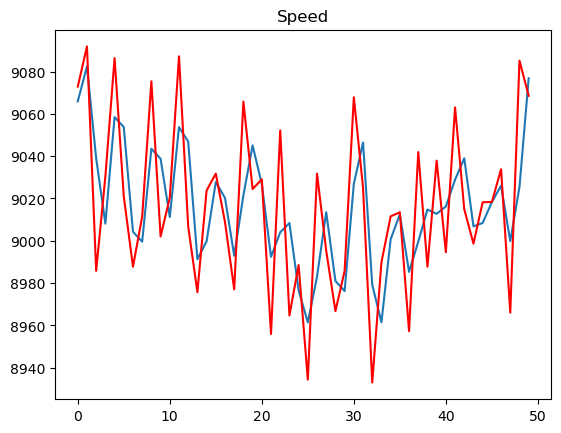

In [100]:
plt.plot(speed[1000:1050])
plt.plot(g.get_group((1500, 0))["en2speed"][1000:1050].reset_index(drop=True), color="red")
plt.title("Speed")

Text(0.5, 1.0, 'Acceleration')

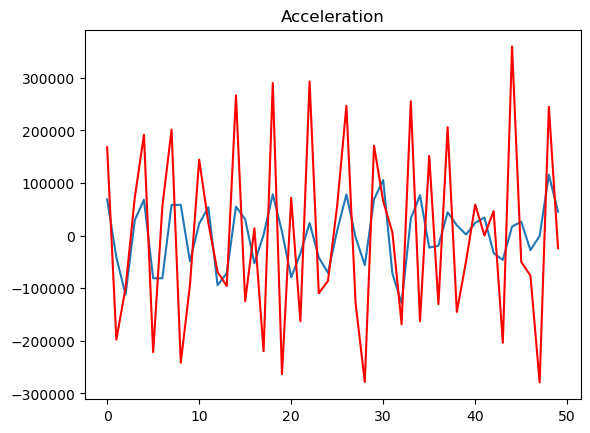

In [101]:
plt.plot(acc[1000:1050])
plt.plot(g.get_group((1500, 0))["en2acc"][1003:1053].reset_index(drop=True), color="red")
plt.title("Acceleration")

Text(0.5, 1.0, 'Speed and acceleration (scaled) w/ np.gradient')

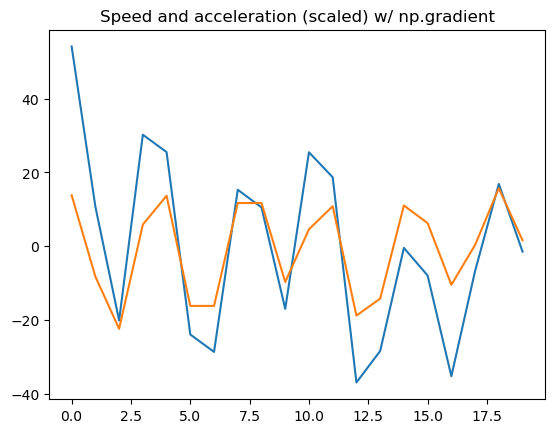

In [102]:
plt.plot(speed[1001:1021] - speed[1001:1021].mean())
plt.plot(acc[1000:1020] / 10000 * 2)
plt.title("Speed and acceleration (scaled) w/ np.gradient")

Text(0.5, 1.0, 'Speed and acceleration (scaled) w/ np.diff')

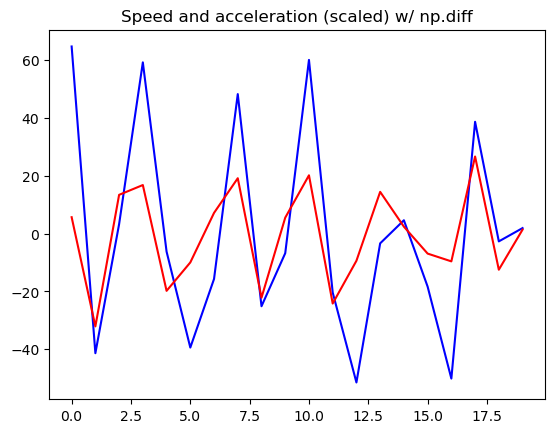

In [103]:
plt.plot(g.get_group((1500, 0))["en2speed"][1001:1021].reset_index(drop=True) - g.get_group((1500, 0))["en2speed"][1001:1021].reset_index(drop=True).mean(), color="blue")
plt.plot(g.get_group((1500, 0))["en2acc"][1000:1020].reset_index(drop=True) / 10000, color="red")
plt.title("Speed and acceleration (scaled) w/ np.diff")

In [141]:
a = torch.rand((250, 2169))
b = torch.concat([a, torch.zeros((250, 1927))], dim=-1)
print(b.shape)

def asd(M):
    return torch.fft.fft(M)

def asd2(M):
    for s in M:
        torch.fft.rfft(s)

torch.Size([250, 4096])


In [142]:
%timeit -n 1000 asd2(a)

9.91 ms ± 11.2 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [143]:
%timeit -n 1000 asd2(b)

4.13 ms ± 34.5 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [144]:
%timeit -n 1000 asd(a)

4.04 ms ± 11.6 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [146]:
%timeit -n 1000 asd(b)

1.53 ms ± 14.2 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


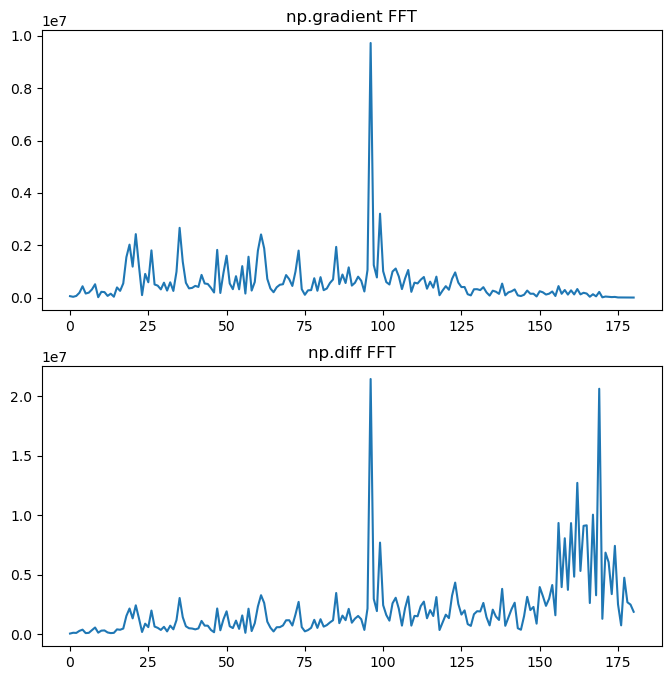

In [167]:
shift = 15000
L = 361

fft_grad_acc = np.abs(np.fft.rfft(acc[shift:shift+L]))
fft_diff_acc = np.abs(np.fft.rfft(g.get_group((1500, 0))["en2acc"][shift:shift+L].reset_index(drop=True)))

fig, ax = plt.subplots(2, 1, figsize=(8, 8))
ax = ax.flatten()

ax[0].set_title("np.gradient FFT")
ax[0].plot(fft_grad_acc)
ax[1].set_title("np.diff FFT")
ax[1].plot(fft_diff_acc)

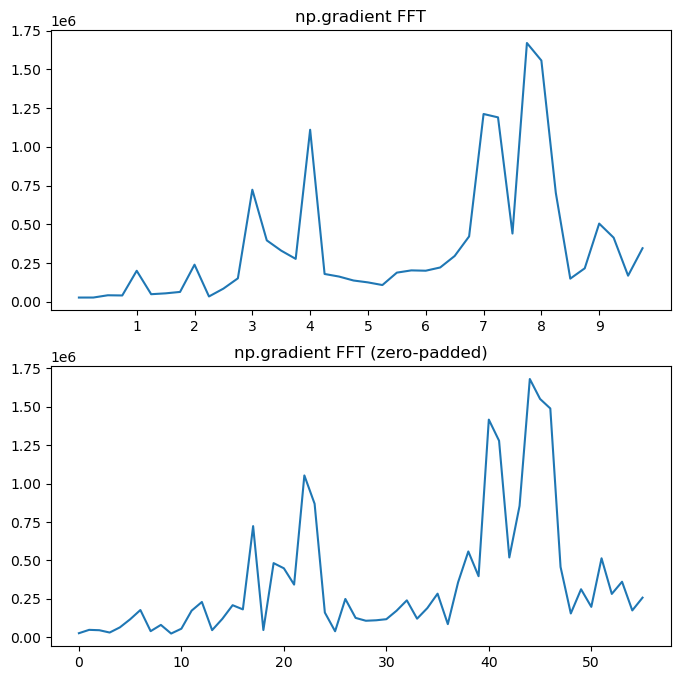

In [168]:
shift = 15000
L = 361 * 4
padded_L = 2048
# 8192
# 2048
# 512
components = 40
scaled_components = int(padded_L / L * components) 

fft_grad_acc = np.abs(np.fft.rfft(acc[shift:shift+L]))
padded = np.concatenate([acc[shift:shift+L], np.zeros(padded_L - L)])
fft_grad_acc_padded = np.abs(np.fft.rfft(padded))

fig, ax = plt.subplots(2, 1, figsize=(8, 8))
ax = ax.flatten()

ax[0].set_title("np.gradient FFT")
ax[0].plot(fft_grad_acc[:components])
x_ticks = np.arange(4, components, step=4)
x_labels = [int(i / 4) for i in x_ticks]
ax[0].set_xticks(ticks=x_ticks, labels=x_labels)

ax[1].set_title("np.gradient FFT (zero-padded)")
ax[1].plot(fft_grad_acc_padded[:scaled_components])

#### FFT checks

tensor(0.0380, dtype=torch.float64)
tensor(0.0126, dtype=torch.float64)
tensor(0.0228, dtype=torch.float64)
tensor(0.0366, dtype=torch.float64)


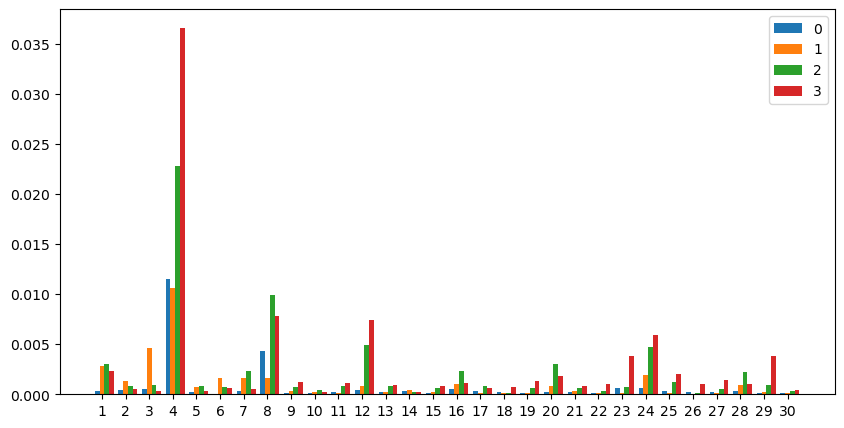

In [19]:
ww = 2169 * 4
shift = 150000
components = 30

fft0 = torch.tensor(data_0_250["acc1"][shift:shift+ww].values)
fft0 = torch.fft.rfft(fft0, norm="forward")[1:]
fft0 = torch.abs(fft0)
print(max(fft0))

fft1 = torch.tensor(data_1_250["acc1"][shift:shift+ww].values)
fft1 = torch.fft.rfft(fft1, norm="forward")[1:]
fft1 = torch.abs(fft1)
print(max(fft1))

fft2 = torch.tensor(data_2_250["acc1"][shift:shift+ww].values)
fft2 = torch.fft.rfft(fft2, norm="forward")[1:]
fft2 = torch.abs(fft2)
print(max(fft2))

fft3 = torch.tensor(data_3_250["acc1"][shift:shift+ww].values)
fft3 = torch.fft.rfft(fft3, norm="forward")[1:]
fft3 = torch.abs(fft3)
print(max(fft3))

ticks = torch.arange(1, components+1)
width = 0.2

plt.figure(figsize=(10,5))
plt.bar(ticks-width*1, fft0[:components], width, label="0")
plt.bar(ticks, fft1[:components], width, label="1")
plt.bar(ticks+width*1, fft2[:components], width, label="2")
plt.bar(ticks+width*2, fft3[:components], width, label="3")

plt.xticks(ticks)
plt.legend(loc='best')
plt.show()

tensor(0.1291, dtype=torch.float64)
tensor(0.2170, dtype=torch.float64)
tensor(0.1738, dtype=torch.float64)
tensor(0.2061, dtype=torch.float64)


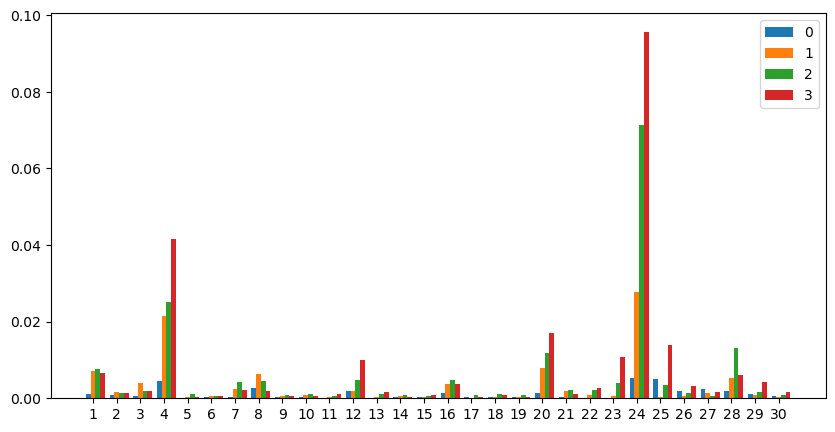

In [20]:
ww = 723 * 4
shift = 150000
components = 30

fft0 = torch.tensor(data_0_750["acc1"][shift:shift+ww].values)
fft0 = torch.fft.rfft(fft0, norm="forward")[1:]
fft0 = torch.abs(fft0)
print(max(fft0))

fft1 = torch.tensor(data_1_750["acc1"][shift:shift+ww].values)
fft1 = torch.fft.rfft(fft1, norm="forward")[1:]
fft1 = torch.abs(fft1)
print(max(fft1))

fft2 = torch.tensor(data_2_750["acc1"][shift:shift+ww].values)
fft2 = torch.fft.rfft(fft2, norm="forward")[1:]
fft2 = torch.abs(fft2)
print(max(fft2))

fft3 = torch.tensor(data_3_750["acc1"][shift:shift+ww].values)
fft3 = torch.fft.rfft(fft3, norm="forward")[1:]
fft3 = torch.abs(fft3)
print(max(fft3))

ticks = torch.arange(1, components+1)
width = 0.2

plt.figure(figsize=(10,5))
plt.bar(ticks-width*1, fft0[:components], width, label="0")
plt.bar(ticks, fft1[:components], width, label="1")
plt.bar(ticks+width*1, fft2[:components], width, label="2")
plt.bar(ticks+width*2, fft3[:components], width, label="3")

plt.xticks(ticks)
plt.legend(loc='best')
plt.show()

tensor(0.3275, dtype=torch.float64)
tensor(0.3529, dtype=torch.float64)
tensor(0.4453, dtype=torch.float64)
tensor(0.2614, dtype=torch.float64)


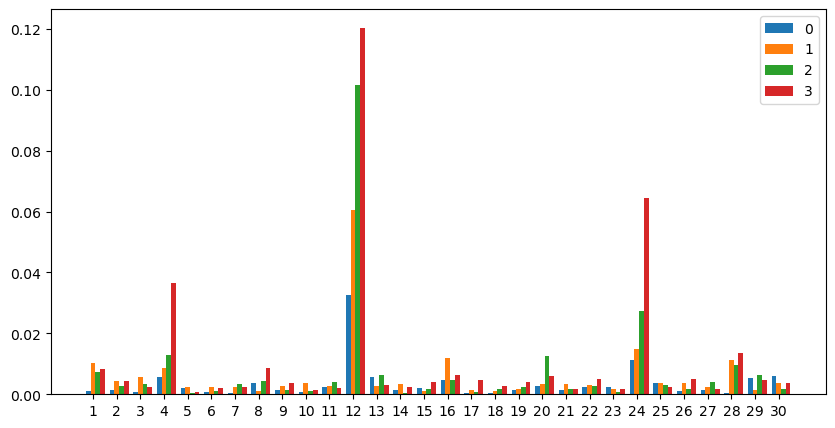

In [23]:
ww = 361 * 4
# ww = math.floor(361 * 1/3)
shift = 100000
components = 30

fft0 = torch.tensor(data_0_1500["acc1"][shift:shift+ww].values)
fft0 = torch.fft.rfft(fft0, norm="forward")[1:]
fft0 = torch.abs(fft0)
print(max(fft0))

fft1 = torch.tensor(data_1_1500["acc1"][shift:shift+ww].values)
fft1 = torch.fft.rfft(fft1, norm="forward")[1:]
fft1 = torch.abs(fft1)
print(max(fft1))

fft2 = torch.tensor(data_2_1500["acc1"][shift:shift+ww].values)
fft2 = torch.fft.rfft(fft2, norm="forward")[1:]
fft2 = torch.abs(fft2)
print(max(fft2))

fft3 = torch.tensor(data_3_1500["acc1"][shift:shift+ww].values)
fft3 = torch.fft.rfft(fft3, norm="forward")[1:]
fft3 = torch.abs(fft3)
print(max(fft3))

ticks = torch.arange(1, components+1)
width = 0.2

plt.figure(figsize=(10,5))
plt.bar(ticks-width*1, fft0[:components], width, label="0")
plt.bar(ticks, fft1[:components], width, label="1")
plt.bar(ticks+width*1, fft2[:components], width, label="2")
plt.bar(ticks+width*2, fft3[:components], width, label="3")

plt.xticks(ticks)
plt.legend(loc='best')
plt.show()

In [115]:
sim3_03 = pd.read_csv(os.path.join(raw_data_folder, "ARotor", "003_3sim_csv", "1500rpm_0030_3sim_new_0.csv"), delimiter=";")["acc1"]
sim3_05 = pd.read_csv(os.path.join(raw_data_folder, "ARotor", "005_3sim_csv", "1500rpm_0050_3sim_0.csv"), delimiter=";")["acc1"]

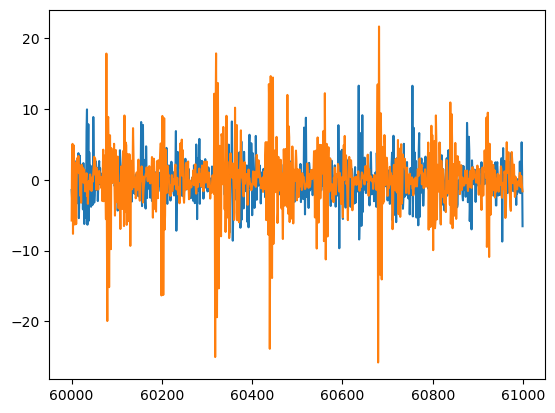

In [118]:
plt.plot(sim3_03[60000:60000+1000])
plt.plot(sim3_05[60000:60000+1000])

### Crude check

**Note:** Some of the measurements seem to have irregularities or something at the end.

In [ ]:
data_500_3x1mm = pd.read_csv(os.path.join(raw_data_folder, "ARotor", "001_3sim_csv", "250rpm_001_3sim_0.csv"), delimiter=";")
data_250_2x3mm = pd.read_csv(os.path.join(raw_data_folder, "ARotor", "003_2sim_csv", "250rpm_0030_2sim_new_0.csv"), delimiter=";")
data_1500_3x5mm = pd.read_csv(os.path.join(raw_data_folder, "ARotor", "005_3sim_csv", "1500rpm_0050_3sim_0.csv"), delimiter=";")

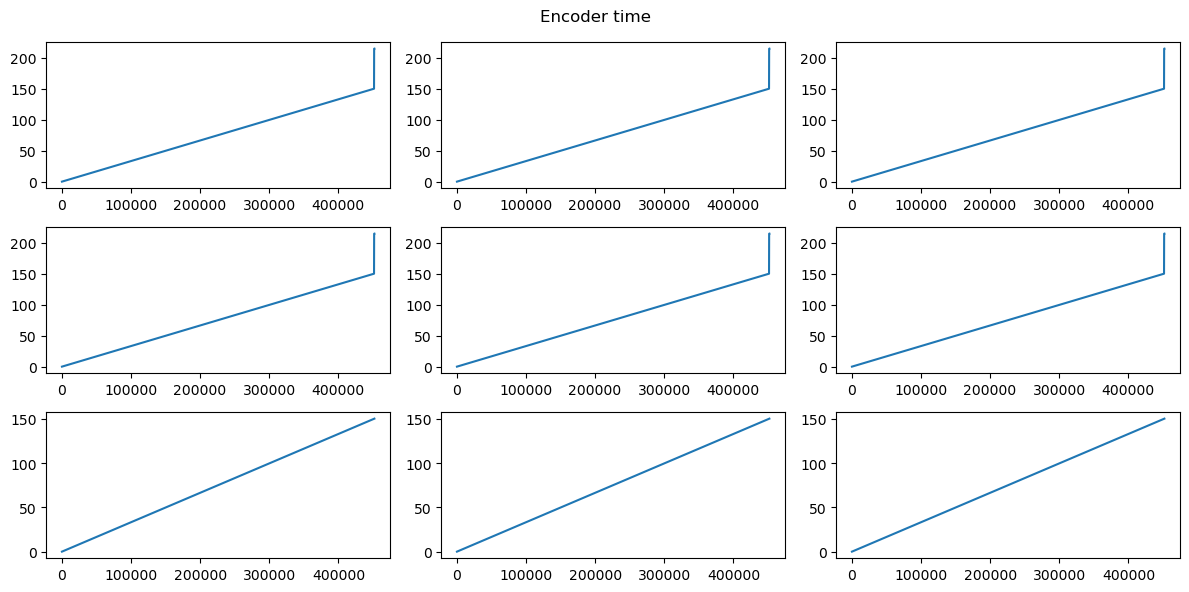

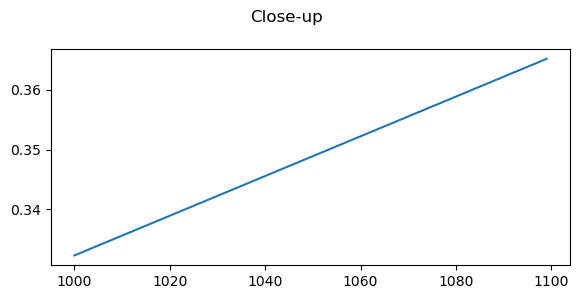

In [8]:
# Check encoder data

fig, axs = plt.subplots(3, 3, figsize=(12, 6))
axs = axs.flatten()

fig.suptitle("Encoder time")

for i, d in enumerate([data_500_3x1mm, data_250_2x3mm, data_1500_3x5mm]):
    axs[i * 3].plot(d["en1time"])
    axs[i * 3 + 1].plot(d["en3time"])
    axs[i * 3 + 2].plot(d["en5time"])

plt.tight_layout()
plt.show()

fig = plt.figure(figsize=(6, 3))
fig.suptitle("Close-up")

plt.plot(data_500_3x1mm["en1time"][1000:1100])
plt.tight_layout()
plt.show()

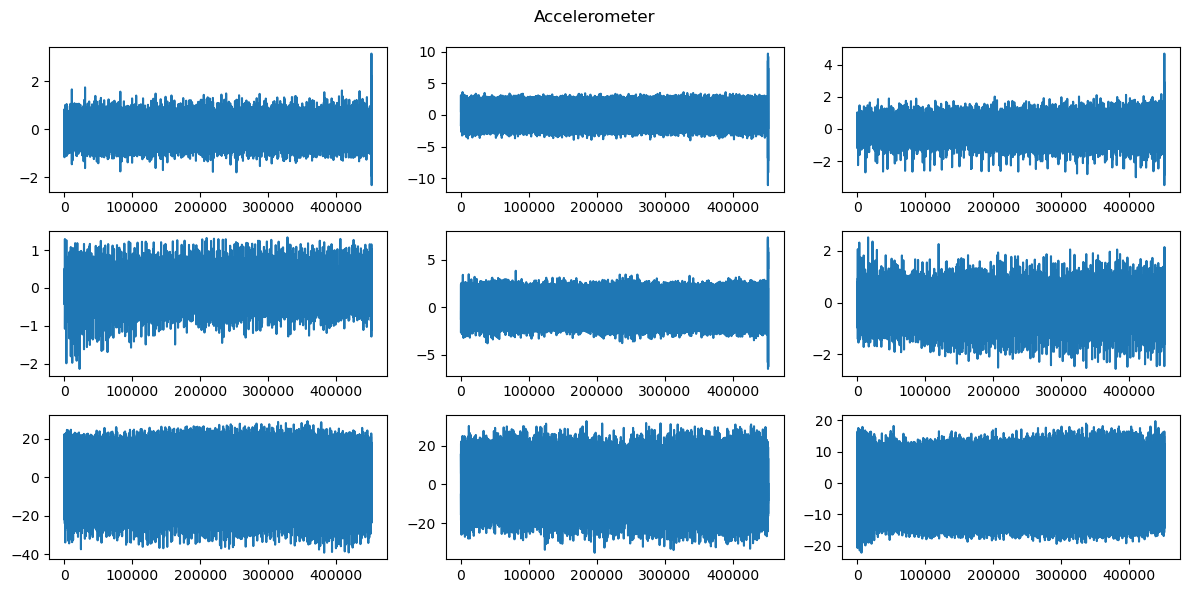

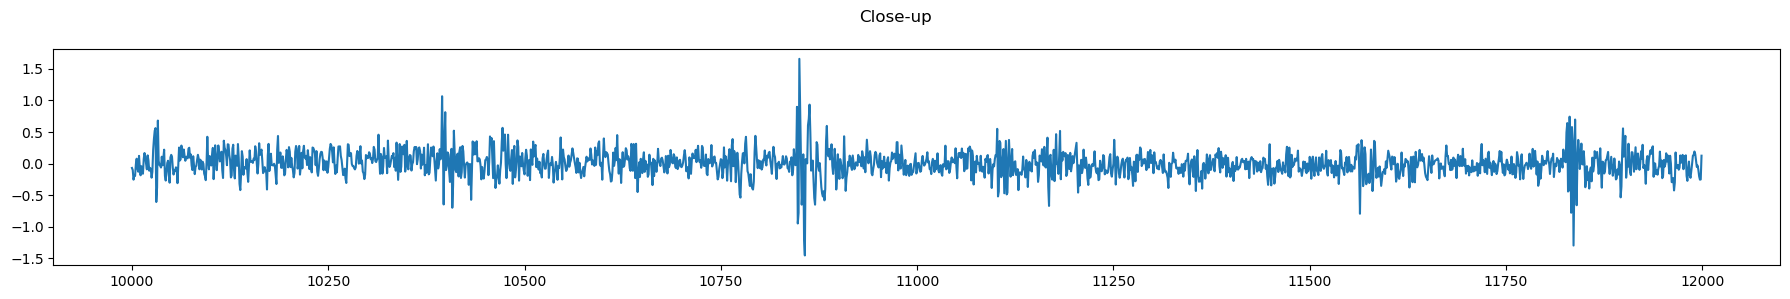

In [9]:
# Check accelerometer data

fig, axs = plt.subplots(3, 3, figsize=(12, 6))
axs = axs.flatten()

fig.suptitle("Accelerometer")

for i, d in enumerate([data_500_3x1mm, data_250_2x3mm, data_1500_3x5mm]):
    axs[i * 3].plot(d["acc1"])
    axs[i * 3 + 1].plot(d["acc2"])
    axs[i * 3 + 2].plot(d["acc4"])

plt.tight_layout()
plt.show()

fig = plt.figure(figsize=(18, 3))
fig.suptitle("Close-up")

plt.plot(data_500_3x1mm["acc1"][10000:12000])
plt.tight_layout()
plt.show()

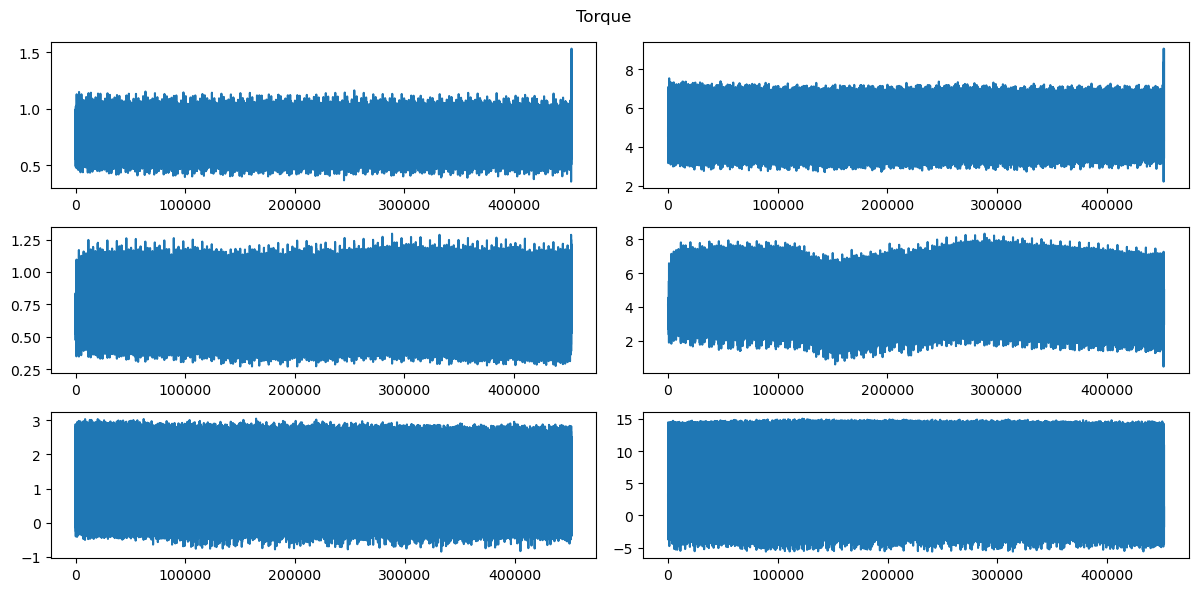

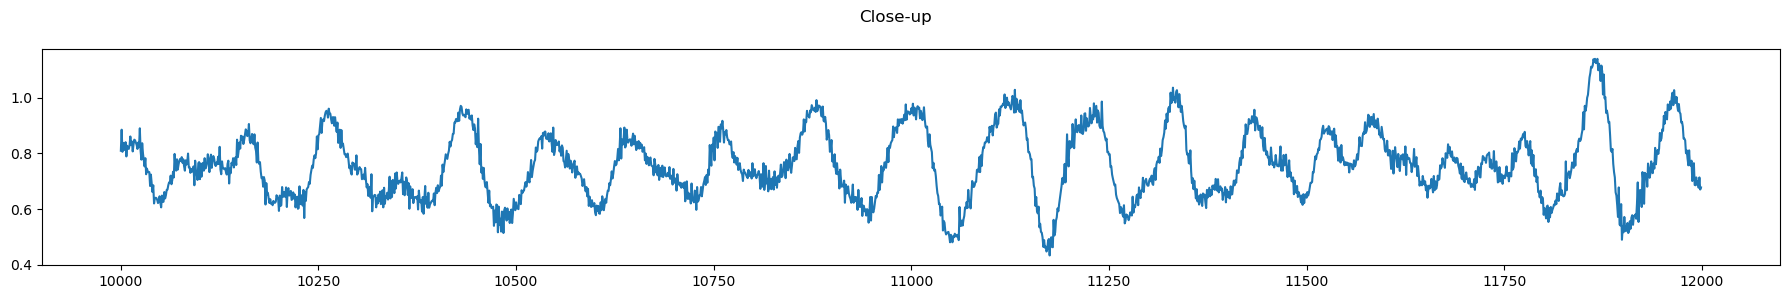

In [10]:
# Check torque data

fig, axs = plt.subplots(3, 2, figsize=(12, 6))
axs = axs.flatten()

fig.suptitle("Torque")

for i, d in enumerate([data_500_3x1mm, data_250_2x3mm, data_1500_3x5mm]):
    axs[i * 2].plot(d["torque1"])
    axs[i * 2 + 1].plot(d["torque2"])

plt.tight_layout()
plt.show()

fig = plt.figure(figsize=(18, 3))
fig.suptitle("Close-up")

plt.plot(data_500_3x1mm["torque1"][10000:12000])
plt.tight_layout()
plt.show()

### Fixes

Remove the irregularities. This was used to determine the amount to cut of the samples for the processing above. Seems like dropping 500 measurement samples is enough.

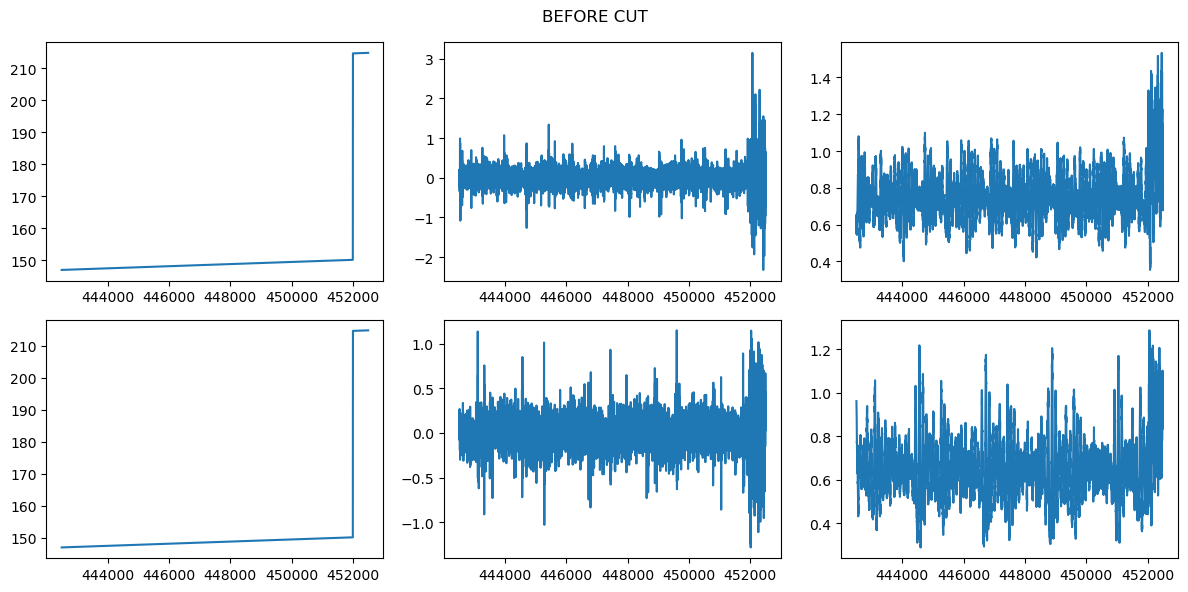

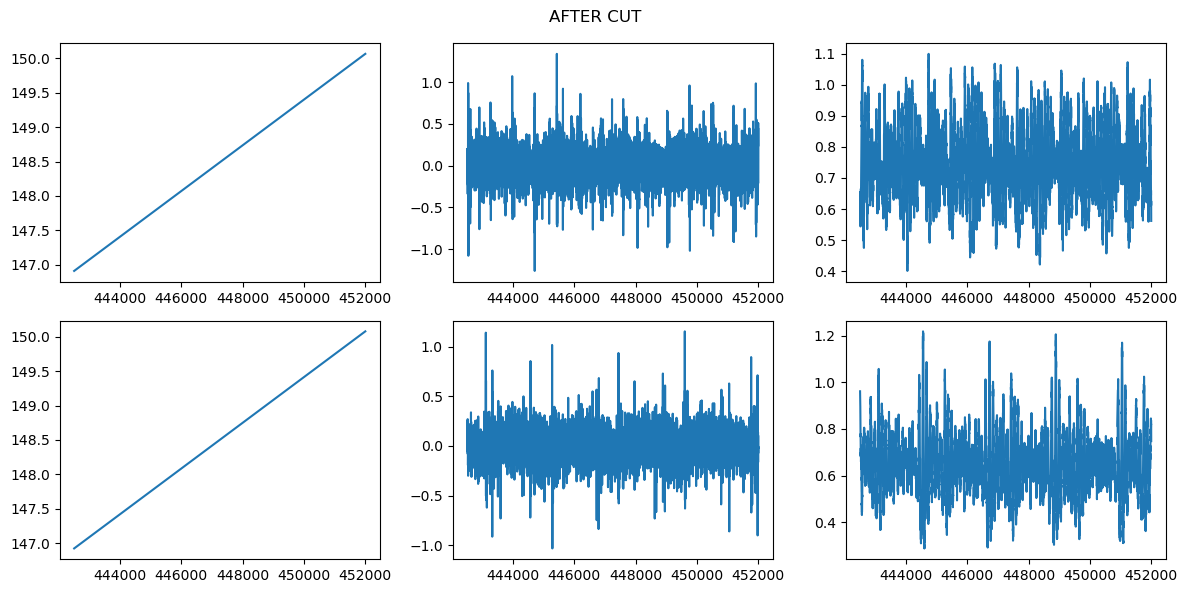

In [11]:
# BEFORE CUT

fig, axs = plt.subplots(2, 3, figsize=(12, 6))
axs = axs.flatten()

fig.suptitle("BEFORE CUT")

for i, d in enumerate([data_500_3x1mm, data_250_2x3mm]):
    axs[i * 3].plot(d["en1time"][-10000:])
    axs[i * 3 + 1].plot(d["acc1"][-10000:])
    axs[i * 3 + 2].plot(d["torque1"][-10000:])


plt.tight_layout()

# AFTER CUT

fig, axs = plt.subplots(2, 3, figsize=(12, 6))
axs = axs.flatten()

fig.suptitle("AFTER CUT")

cut = 500

for i, d in enumerate([data_500_3x1mm, data_250_2x3mm]):
    axs[i * 3].plot(d["en1time"][-10000:-cut])
    axs[i * 3 + 1].plot(d["acc1"][-10000:-cut])
    axs[i * 3 + 2].plot(d["torque1"][-10000:-cut])

plt.tight_layout()